# Extract and standardise ExoFOP time series observations

This notebook demonstrates how to conveniently load and standardise time series observations from ExoFOP.


The main challenge here is achieving consistent column naming across ExoFOP data files.
With a wide range of observatories and processing pipelines contributing to ExoFOP, there are cases
where different column names are used to denote the same underlying concept.
For instance, the column representing time may be labelled as
'BJD TBD', 'time', 'TIME', and so on. 
By mapping all of these synonyms to a primary alias, a consistent and intuitive nomenclature can be achieved, 
regardless of the original source.
To achieve this, we use `SynonymMap(collections.defaultdict)` a dictionary-like class that 
allows the association of synonyms with a primary alias facilitating the standardisation of column names.

Here is an example that illustrates how this class works.

In [1]:
from exofop.extract import LightCurveTableList, LightCurveTable, SynonymMap, SynonymMapLc

# For nice logs, we reformat the root loggger's StreamHandler
from exofop.utils.logger import configure_root_logger
configure_root_logger()

In [2]:
# Initialise a synonym map from a dictionary
synonym_map = SynonymMap()

# Define a primary alias and its synonyms
synonym_map['primary_alias_a'] = ['synonym_a_0', 'synonym_a_1', 'synonym_a_2']

# Alternatively, we can use `update` to add multiple primary aliases at once
synonym_map.update(
    {
        'primary_alias_b': ['synonym_b_0', 'synonym_b_1', 'synonym_b_2'],
        'primary_alias_c': ['synonym_c_0'],
    }
)

# If we realise that we were missing a synonym of `primary_alias_a`, we can add it
synonym_map.add_synonyms('primary_alias_a', 'synonym_a_3')

# And if we want to rename `primary_alias_b` to `primary_alias_b_new`, we can do so
synonym_map.rename_primary_alias('primary_alias_b', 'new_primary_alias_b_new')

synonym_map

SynonymMap(tuple,
           {'primary_alias_a': ('synonym_a_0',
             'synonym_a_1',
             'synonym_a_2',
             'synonym_a_3'),
            'primary_alias_c': ('synonym_c_0',),
            'new_primary_alias_b_new': ('synonym_b_0',
             'synonym_b_1',
             'synonym_b_2',
             'primary_alias_b')})

## Extract the data

The extracted data is contained in a list of `LightCurveTable` objects.
This class extends the functionality of its parent class `astropy.table.Table`, giving access to additional attribute stored in the `meta` attribute of the table and providing various methods.

In [3]:
target_dir = './TOI_1130'  # As generated in the previous tutorial

exofop_data = LightCurveTableList.load_exofop_data(
        target_dir=target_dir,
        observation_names=None,  # defaults to all folders in data_dir
        allow_multiple_filetypes=True,
    )
exofop_data

13:56:12 :: INFO     :: Tags of datasets processed: 5903


LightCurveTableList(['5903'])

All successfully loaded tables can be inspected by index or name using

In [4]:
exofop_data[-1][:5]

BJD_TDB,rel_flux_T1_n,rel_flux_err_T1_n,mag,mag_err,var_imag,comp_imag,x_coord,y_coord,dist_center,fwhm,airmass,sky,rel_flux_mag,rel_flux_err_mag
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2458758.021817,1.0034136391780677,0.0014786849841141282,11.3739,0.0016,11.3001,11.9067,813.5899,462.2884,68.0983,2.9442,1.0847,472.4629,1.0034136391780677,0.0014786849841141282
2458758.0226434,1.0069316688518022,0.0014838693442315374,11.3701,0.0016,11.2935,11.9054,812.7702,461.7691,67.8838,3.1278,1.0864,444.0818,1.0069316688518022,0.0014838693442315374
2458758.0234726,1.000644931705117,0.0014746048659995184,11.3769,0.0016,11.298,11.903,813.2566,461.4115,68.4802,3.3411,1.0882,450.5804,1.000644931705117,0.0014746048659995184
2458758.0251323,1.0025822235150676,0.0014774597647146364,11.3748,0.0016,11.2945,11.9,813.8261,460.7488,69.3518,2.9926,1.0918,425.4003,1.0025822235150676,0.0014774597647146364
2458758.0259552,1.0056341199160994,0.0014819572054559985,11.3715,0.0016,11.2924,11.9031,813.3081,460.5687,69.1168,2.8176,1.0936,443.6741,1.0056341199160994,0.0014819572054559985


All information extracted from the file names is contained in the `.meta` attribute of each `LightCurveTable`.

In [5]:
exofop_data[0].meta

{'target': 'TIC254113311',
 'pp': 1,
 'yyyymmdd': '2019-10-01',
 'observatory': 'PEST',
 'filter': 'Rc',
 'filetype': 'data',
 'ext': 'txt',
 'full_file_name': 'TIC254113311-01_20191001_PEST_Rc_data.txt',
 'jd': 2458757.5,
 'is_complete': True,
 'name': '5903'}

## Standardise essential light curve attributes

Standardisation of the column names in `LightCurveTable` objects is achieved using instances of either `SynonymMap` or `SynonymMapLc`. `SynonymMapLc` is a subclass of SynonymMap specifically tailored for handling attributes related to light curves.
It provides additional functionality to manipulate primary aliases and their synonyms, with default attributes for time, flux, and flux error.
By default, `LightCurveTable().synonym_map` provides a set of synonyms used for standardization. However, creating a custom synonym map allows for tailored adjustments to better suit specific needs.

Let's delve into creating a custom synonym map to demonstrate its utility and ease of refinement.

In [6]:
simple_synonym_map = SynonymMapLc()
simple_synonym_map.update(
    {
        'BJD_TDB': ('time', 'TIME', 'BJD', 'BJD_TDB_MOBS', '#BJD_TDB'),
        'rel_flux_T1_n': ('flux', 'FLUX', 'rel_flux', 'rel_flux_T1'),
        'rel_flux_err_T1_n': ('flux_err', 'ERRFLUX', 'rel_flux_err_T1')
    }
)
print(simple_synonym_map.light_curve_attributes)
print(simple_synonym_map)

EssentialLightcurveAttributes(time='BJD_TDB', flux='rel_flux_T1_n', flux_err='rel_flux_err_T1_n')
SynonymMapLc(<class 'tuple'>, {'BJD_TDB': ('time', 'TIME', 'BJD', 'BJD_TDB_MOBS', '#BJD_TDB'), 'rel_flux_T1_n': ('flux', 'FLUX', 'rel_flux', 'rel_flux_T1'), 'rel_flux_err_T1_n': ('flux_err', 'ERRFLUX', 'rel_flux_err_T1')})


Next, we utilize `simple_synonym_map` to search for secondary aliases within the column names of each table. This search is performed for each primary alias that is not already present in the table.

Following this, we then check for any discrepancies between the time given in the table and the time stamp specified in the measurement file name. This verification step is crucial because CSV files may sometimes express time relative to a reference point, such as 2 450 000 BJD. If a discrepancy is detected, a reference time is inferred based on the disparity between the timestamp of the file name and the time column. This reference time is then rounded and added to the time column to ensure consistency. A warning log informs the user whenever a time correction is applied.

In [7]:
exofop_data.standardise_column_names(synonym_map=simple_synonym_map)
exofop_data.apply_time_correction_in_case_of_discrepancy()

13:56:12 :: INFO     :: All observations contain a complete light curve.


We can also view an information summary table for all measurements.

In [8]:
exofop_data.info_df

,Date,BJD,Observatory,Filter,target,pp,Measurement file name,full_file_name,texp,Duration,Efficiency,cbvs,ncols
5903,2019-10-01,2458757,PEST,Rc,TIC254113311,1,data.txt,TIC254113311-01_20191001_PEST_Rc_data.txt,23.852154,3.968364,75.4,15,15


If matplotlib is installed, you can also visually inspect any complete and standardised the light curve:

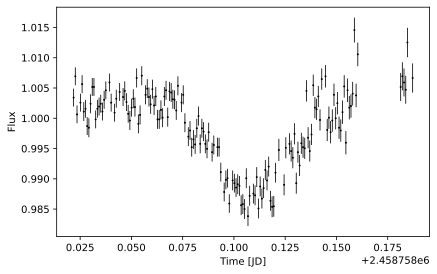

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

fig, ax = plt.subplots(1, figsize=(6.69, 4.14))
exofop_data[-1].errorbar(ax=ax, ls='', marker='.', markersize=2, alpha=1, color='black')

plt.show()

## Standardise naming of cotrending basis vectors (CBVs)


In this package, we employ the term Cotrending Basis Vectors (CBVs) to denote a collection of vectors commonly utilized for mitigating systematic effects in time-series data. Examples of such CBVs include:
- **AIRMASS**: The optical path length through Earth's atmosphere when observing a celestial object. It accounts for atmospheric refraction and absorption, impacting the observed brightness and position of celestial objects.
- **Sky/Pixel**: The background sky brightness associated with a particular set of pixel in an image. This metric helps in accounting for varying levels of sky illumination across the detector array, which can affect the measured signal from celestial objects.
- **X(IJ)/Y(IJ)**: Spatial coordinates of a pixel within the detector array. These coordinates define the precise location of a pixel in the two-dimensional imaging plane, aiding in accurate positional calibration and image alignment.
- **FWHM**: Full Width at Half Maximum is a measurement used to quantify the width of a distribution. In the context of photometry, it quantifies the extent of blurring or spreading of the point spread function (PSF) of a star or celestial object in an image. FWHM provides crucial information about the spatial resolution and image quality, influencing the precision of photometric measurements.

Unlike `time`, `flux` and `flux_err`, which are essential for a complete light curve, CBVs are optional - although highly desirable to decrease the amount of red noise present in the data.

Let's try and standardise their column names

In [10]:
synonym_map = simple_synonym_map.deepcopy()
synonym_map.update(
    {
        "AIRMASS": ("AIRMASS"),  # ("airmass"),
        "Sky/Pixel_T1": ("sky", "SKY"),
        "X(IJ)_T1": ("x_coord"),
        "Y(IJ)_T1": ("y_coord"),
        "FWHM_T1": ("fwhm", "FWHM"),
    }
)

# To get the names of all primary aliases in the synonym map that are not part of the light curve
print("CBVs:", synonym_map.cbv_names)

exofop_data.standardise_column_names(synonym_map)

13:56:13 :: INFO     :: All observations contain a complete light curve.


CBVs: ['AIRMASS', 'Sky/Pixel_T1', 'X(IJ)_T1', 'Y(IJ)_T1', 'FWHM_T1']


Lets see if there are datasets that are missing any CBVs.

In [11]:
# We seem to be missing the cotrending basis vector airmass for the first light curve
exofop_data.missing_cbvs(synonym_map=synonym_map)

{'5903': ('PEST', ['AIRMASS'])}

The observations from PEST seemt to be missing the `AIRMASS`. Let's see if there is indeed no column corresponding to airmass in this table, or if they are using a synonym that we haven't come across yet.

In [12]:
[np.array(exofop_data[name].colnames) for name in exofop_data.missing_cbvs()]

[array(['BJD_TDB', 'rel_flux_T1_n', 'rel_flux_err_T1_n', 'mag', 'mag_err',
        'var_imag', 'comp_imag', 'X(IJ)_T1', 'Y(IJ)_T1', 'dist_center',
        'FWHM_T1', 'airmass', 'Sky/Pixel_T1', 'rel_flux_mag',
        'rel_flux_err_mag'], dtype='<U17')]

So they do in fact have a column called `airmass`. Lets add that synonym and rerun the standardisation.

In [13]:
synonym_map.add_synonyms('AIRMASS', 'airmass')
exofop_data.standardise_column_names(synonym_map)

exofop_data.missing_cbvs(synonym_map=synonym_map)

13:56:13 :: INFO     :: All observations contain a complete light curve.


If no synonym map is provided, `LightCurveTable().synonym_map` is used. If you find additional synonyms that you want to keep permanently, you can save them, using
`synonym_map.save()` or `synonym_map.save_to_config()`.

In [14]:
LightCurveTable().synonym_map

SynonymMapLc(tuple,
             {'AIRMASS': ('airmass',),
              'BJD_TDB': ('time', 'TIME', 'BJD', 'BJD_TDB_MOBS', '#BJD_TDB'),
              'FWHM_T1': ('fwhm', 'FWHM'),
              'Sky/Pixel_T1': ('sky', 'SKY'),
              'X(IJ)_T1': ('x_coord',),
              'Y(IJ)_T1': ('y_coord',),
              'rel_flux_T1_n': ('flux',
               'FLUX',
               'rel_flux',
               'rel_flux_T1',
               'flux_star_0'),
              'rel_flux_err_T1_n': ('flux_err', 'ERRFLUX', 'rel_flux_err_T1')})

Now the data is in a standardised form, ready to be analysed further with the probabilistic time series modelling tool of your choice.

Your `light_curve' and `cbvs' can be conveniently accessed and converted to numpy.

In [15]:
exofop_data[0].light_curve().to_pandas()

,BJD_TDB,rel_flux_T1_n,rel_flux_err_T1_n
0,2.458758e+06,1.003414,0.001479
1,2.458758e+06,1.006932,0.001484
2,2.458758e+06,1.000645,0.001475
3,2.458758e+06,1.002582,0.001477
4,2.458758e+06,1.005634,0.001482
...,...,...,...
150,2.458758e+06,1.006932,0.002319
151,2.458758e+06,1.005912,0.002316
152,2.458758e+06,1.004708,0.002313
153,2.458758e+06,1.012512,0.002425


In [16]:
exofop_data[0].cbvs().to_pandas()

,AIRMASS,FWHM_T1,Sky/Pixel_T1,X(IJ)_T1,Y(IJ)_T1
0,1.0847,2.9442,472.4629,813.5899,462.2884
1,1.0864,3.1278,444.0818,812.7702,461.7691
2,1.0882,3.3411,450.5804,813.2566,461.4115
3,1.0918,2.9926,425.4003,813.8261,460.7488
4,1.0936,2.8176,443.6741,813.3081,460.5687
...,...,...,...,...,...
150,2.3950,3.6697,537.8053,817.3280,466.8125
151,2.4137,3.4809,537.7516,817.5697,467.7563
152,2.4337,3.6952,514.5619,818.7373,468.5323
153,2.4531,4.0062,529.9705,817.5272,469.4299


Finally, we can update the overview table and now see that both datasets contain the 5 CBVs we selected above.

In [17]:
exofop_data.update_info_df()
exofop_data.info_df

,Date,BJD,Observatory,Filter,target,pp,Measurement file name,full_file_name,texp,Duration,Efficiency,cbvs,ncols
5903,2019-10-01,2458757,PEST,Rc,TIC254113311,1,data.txt,TIC254113311-01_20191001_PEST_Rc_data.txt,23.852154,3.968364,75.4,5,15


## Save standardised data
There are two options to save the standardised data:
- `exofop_data.save(save_dir: str)`: Saves all tables individually to save_dir with `tbl.name` as file name. Additionally, the `info_df` is saved to the same folder. `LightCurveTableList.load(cls, load_dir: str)` can then be used to reload the data.
- `exofop.save_to_pickle(file_path: str)`: Saves the object to a pickle file, which can be reloaded using `LightCurveTableList.load_from_pickle(file_path: str)`

In [18]:
exofop_data.save(save_dir=None)
print("Saved to",  exofop_data.default_save_dir)

Saved to ./TOI_1130/output


We can later reload all files again using

In [19]:
LightCurveTableList.load(load_dir=exofop_data.default_save_dir)

LightCurveTableList(['5903'])

## Conclusion

In this notebook, we've shown how to extract ExoFOP light curves from a set of folders and brought 
the measurement files of each observation into a standardised format.